In [13]:
using CSV, DataFrames, Gurobi, JuMP, LinearAlgebra, Plots, Clustering, StableRNGs, Random, Statistics

In [14]:
function read_data(file, scaling)
    # normalized_root = "./normalized_data"
    # scaled_root = "./scaled_data"
    
    if scaling == "normalized"
        data = CSV.read("./normalized_data/$file", DataFrame)
        for c in names(data, Any)
            data[!, c]= Float64.(data[!, c])
        end
        return data
    elseif scaling == "processed"
        data = CSV.read("./processed_data/$file", DataFrame)
        for c in names(data, Any)
            data[!, c]= Float64.(data[!, c])
        end
        return data
    else
        data = CSV.read("./scaled_data/$file", DataFrame)
        for c in names(data, Any)
            data[!, c]= Float64.(data[!, c])
        end
        return data
    end
end

function k_means_cluster(data, k; seed=0)
    # Documentation: https://clusteringjl.readthedocs.io/en/latest/kmeans.html
    Random.seed!(seed)
    data_matrix = Matrix(data)
    kmeans_result = Clustering.kmeans(data_matrix', k; rng=StableRNG(seed))
        # kmeans_result.totalcost (within-cluster sum of square distance)
        # a = assignments(kmeans_result) # get the assignments of points to clusters
        # c = counts(kmeans_result) # get the cluster sizes
        # M = kmeans_result.centers # get the cluster centers
    return kmeans_result
end

function k_medoids_cluster(data, k, distance="euclidean", seed=0)
    Random.seed!(seed)
    data_matrix = Matrix(data)
    distance_matrix = zeros(size(data_matrix)[1], size(data_matrix)[1])
    
    for i in 1:size(data_matrix)[1]
        for j in 1:size(data_matrix)[1]
            if distance == "manhattan"
                distance_matrix[i, j] = sum(data_matrix[i, :] .- data_matrix[j, :])^2
            else
                distance_matrix[i, j] = norm(data_matrix[i, :] .- data_matrix[j, :])^2
            end
        end
    end
    
    kmedoids_result = kmedoids(distance_matrix, k)
    # kmedoids_result.totalcost (within-cluster sum of square distance)
    # a = assignments(kmeans_result) # get the assignments of points to clusters
    # c = counts(kmeans_result) # get the cluster sizes
    # M = kmeans_result.medoids # get index number of medoids observations (ordered from k=1, ..., k=K
    return kmedoids_result
end

function evaluate_clustering(data, assignments, centers, distance)
    data_matrix = Matrix(data)
    K = maximum(assignments)
    n, p = size(data_matrix)

    wcssd = zeros(K)

    for k in 1:K
        cluster_obs = data_matrix[assignments .== k, :]
        for i in 1:size(cluster_obs)[1]
            if distance == "manhattan"
                wcssd[k] += sum(abs.(cluster_obs[i, :] .- centers[k, :]))^2
            else  
                wcssd[k] += norm(cluster_obs[i, :] .- centers[k, :])^2
            end
        end
    end

    return sum(wcssd)
end

function get_assignments(model)
    z_values = value.(model[:z])  
    n, k_max = size(z_values)
    assignments = zeros(Int, n)

    for i in 1:n
        for k in 1:k_max
            if z_values[i, k] > 0.5  
                assignments[i] = k
                break
            end
        end
    end

    return assignments
end

function get_centers(model)
    c_values = value.(model[:c])  
    return c_values
end

get_centers (generic function with 1 method)

In [3]:
function kmedoids_optimal(data, num_rows, distance, k_max, time_limit, warm_start=true, seed=1)
    
    data = Matrix(data[1:num_rows, :])
    n = size(data)[1]
    p = size(data)[2]
    
    observation_range = 1:n
    variable_range = 1:p
    cluster_range = 1:k_max
    big_M = 1e3

    # t = time()
    model = Model(optimizer_with_attributes(Gurobi.Optimizer, "TimeLimit" => time_limit, "Seed" => seed, "OutputFlag" => 0))

    @variable(model,
        m[i in observation_range, k in cluster_range], Bin)
    @variable(model,
        z[i in observation_range, k in cluster_range], Bin)
    @variable(model,
        c[k in cluster_range, j in variable_range])
    @variable(model,
        d[i in observation_range, j in variable_range] >= 0)

    @constraint(model,
        must_have_cluster[i in observation_range],
        sum( (z[i, k]) for k in cluster_range) == 1)
    @constraint(model,
        must_have_medoid[k in cluster_range],
        sum( (m[i, k]) for i in observation_range) == 1)
    @constraint(model,
        medoid_restriction_1[i in observation_range],
        sum( (m[i, k]) for k in cluster_range) <= 1)
    @constraint(model,
        medoid_restriction_2[i in observation_range, k in cluster_range],
        m[i, k] <= z[i, k])
    
    @constraint(model,
        medoid_selection_UB[i in observation_range, j in variable_range, k in cluster_range],
        c[k, j] <= data[i, j] + big_M*(1 - m[i, k]))
    @constraint(model,
        medoid_selection_LB[i in observation_range, j in variable_range, k in cluster_range],
        data[i, j] - big_M*(1 - m[i, k]) <= c[k, j])

    if warm_start == true
        data_kmedoids = k_medoids_cluster(data, k_max, distance, seed)
        heur_medoids = data_kmedoids.medoids

        m_ik = Int64.(zeros(size(data)[1], k_max))
        z_ik = Int64.(zeros(size(data)[1], k_max))
        c_kj = zeros(k_max, size(data)[2])

        cluster = 0
        for index in heur_medoids
            cluster = cluster + 1

            set_start_value(m[index, cluster], 1)
            for j in variable_range
                set_start_value(c[cluster, j], data[index, j])
            end
        end
    
        for index in 1:size(assignments(data_kmedoids))[1]
            set_start_value(z[index, assignments(data_kmedoids)[index]], 1)
        end
    end

    if distance == "manhattan"
        @constraint(model,
            distance_1[i in observation_range, j in variable_range, k in cluster_range],
            d[i, j] >= data[i, j] - c[k, j] - big_M*(1 - z[i, k]))
        @constraint(model,
            distance_2[i in observation_range, j in variable_range, k in cluster_range],
            d[i, j] >= c[k, j] - data[i, j] - big_M*(1 - z[i, k]))
    else
        @constraint(model,
            distance_1[i in observation_range, j in variable_range, k in cluster_range],
            d[i, j] >= (data[i, j] - c[k, j])^2 - big_M*(1 - z[i, k]))
    end

    @objective(model,
        Min,
        sum( sum( (d[i, j]) for j in variable_range) for i in observation_range))

    optimize!(model)
    # dt = time() - t
    # println()
    # println("Running Optimal KMedoids for following args:")
    # println("num_rows=$num_rows, distance=$distance, k_max=$k_max, time_limit=$time_limit, warm_start=$warm_start, seed=$seed")
    # println("Objective function value: $(JuMP.objective_value(model)))")
    # println("Solved in $(round(dt, digits=3)) seconds")
    # println("--------------------------------------------------------------")

    return model
end


kmedoids_optimal (generic function with 3 methods)

In [25]:
data_means = k_means_cluster(data, k_max)
data_means.centers'

5×9 adjoint(::Matrix{Float64}) with eltype Float64:
 0.47861    0.421397   0.46631   …   0.298019   0.615908   1.94703
 0.164835  -1.5577    -1.5591       -1.25085   -1.27239   -1.01973
 0.487329   1.32073    1.3209        1.72219    1.6988     0.697111
 0.297084  -0.27127   -0.275152     -0.489335  -0.475195  -0.190603
 0.488353   0.652964   0.643969      0.541158   0.451976  -0.00729947

In [24]:
data_kmedoids = k_medoids_cluster(data, k_max)
base_centers = Matrix(data[data_kmedoids.medoids, :])

5×9 Matrix{Float64}:
 0.0   0.54964    0.474797   0.250642  …   0.227219   0.270606   0.0205683
 0.0  -1.69862   -1.74205   -1.42292      -1.36473   -1.39244   -1.22006
 1.0   1.29906    1.33131    1.20696       1.58197    1.67144    0.640883
 1.0   0.591275   0.676328   0.728801      0.441607   0.798614   2.19167
 0.0  -0.407952  -0.532863  -0.347058     -0.639457  -0.695611  -0.289589

In [4]:
abalone = read_data("abalone_z.csv", "normalized")
similarity_prediction = read_data("similarity_prediction_z.csv", "normalized");

In [6]:
data = abalone
subset_parameter = 0.75
num_rows = floor(Int, size(abalone)[1] * subset_parameter)
distance = "manhattan"
k_max = 5
warm_start = true
times_tested = [90, 120, 150, 180]

models = []
for time_limit in times_tested
    push!(models, kmedoids_optimal(data, num_rows, distance, k_max, time_limit, warm_start))
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter TimeLimit to value 90
Set parameter Seed to value 1
Set parameter Seed to value 1
Set parameter TimeLimit to value 90

Running Optimal KMedoids for following args:
num_rows=3132, distance=manhattan, k_max=5, time_limit=90, warm_start=true, seed=1
Objective function value: 10923.075199615521)
Solved in 93.81 seconds
--------------------------------------------------------------
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter TimeLimit to value 120
Set parameter Seed to value 1
Set parameter Seed to value 1
Set parameter TimeLimit to value 120

Running Optimal KMedoids for following args:
num_rows=3132, distance=manhattan, k_max=5, time_limit=120, warm_start=true, seed=1
Objective function value: 10923.075199615521)
Solved in 127.595 seconds
--------------------------------------------------------------
Set parameter Username
Ac

In [12]:
# evaluate_clustering(data, assignments, centers, distance)

clustering_assignments = []
clustering_centers = []
warm_starts = []
wcss = []
data_kmedoids = k_medoids_cluster(data, "manhattan", k_max)

for i in 1:length(times_tested)
    push!(warm_starts, data_kmedoids.totalcost)
    push!(clustering_assignments, get_assignments(models[i]))
    push!(clustering_centers, get_centers(models[i]))
    push!(wcss, evaluate_clustering(data[1:num_rows,:], clustering_assignments[i], clustering_centers[i], distance))
end

y_min = minimum(wcss) - 0.2*(maximum(wcss) - minimum(wcss)) - 1
y_max = maximum(wcss) + 0.2*(maximum(wcss) - minimum(wcss)) + 1

scatter(times_tested, wcss, label=false, xlabel="Times Tested", ylabel="WCSS", title="WCSS vs Times Tested", grid=false, color=:blue, ylim=(y_min, y_max))
plot!(times_tested, wcss, label="", line=:solid, color=:blue)

LoadError: MethodError: no method matching kmedoids(::Matrix{Float64}, ::String)

[0mClosest candidates are:
[0m  kmedoids(::AbstractMatrix{T}, [91m::Integer[39m; init, maxiter, tol, display) where T<:Real
[0m[90m   @[39m [36mClustering[39m [90m~/.julia/packages/Clustering/wNDPu/src/[39m[90m[4mkmedoids.jl:62[24m[39m


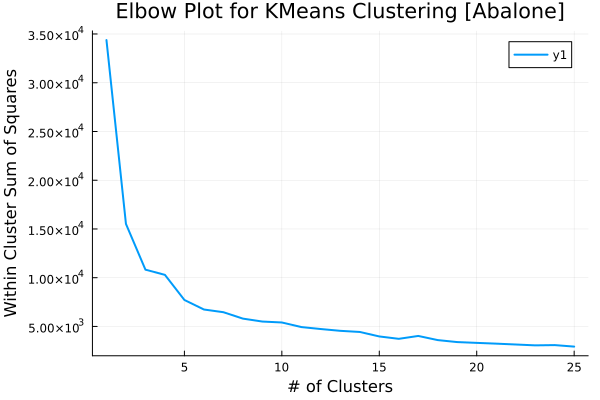

In [70]:
data_matrix = Matrix(abalone)

measure = []
K_max = 25
for k in 1:K_max
    Random.seed!(k)
    kmeans_result = k_medoids_cluster(data_matrix, k_max)
    push!(measure, sum(kmeans_result.totalcost))
end

plot(1:K_max, measure, xlabel="# of Clusters", ylabel="Within Cluster Sum of Squares", title="Elbow Plot for KMeans Clustering [Abalone]", linewidth=2)

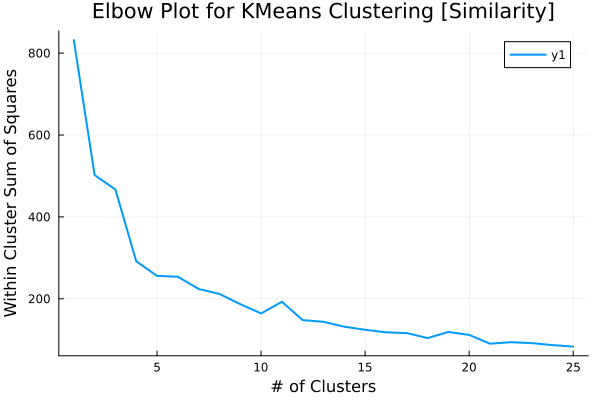

In [71]:
data_matrix = Matrix(similarity_prediction)

measure = []
K_max = 25
for k in 1:K_max
    Random.seed!(k)
    kmeans_result = k_medoids_cluster(data_matrix, k_max)
    push!(measure, sum(kmeans_result.totalcost))
end

plot(1:K_max, measure, xlabel="# of Clusters", ylabel="Within Cluster Sum of Squares", title="Elbow Plot for KMeans Clustering [Similarity]", linewidth=2)